## ORGANS: Transplant by State

This notebook contains analysis of state-level trends in transplants by state.

---

### Initialize environment

In [2]:
library(tidyverse)
library(patchwork)
library(gridExtra)

In [3]:
root_path     <- here::here()
data_path     <- paste0(root_path, "/01_data")
analysis_path <- paste0(root_path, "/02_analysis")

In [4]:
setwd(data_path)

transplant <- readRDS("clean/transplant_clean.rds")

donor <- readRDS("clean/donor_clean.rds")

state_code_mapping <- read.csv("raw/00_misc/state_code_mapping_20221022.csv")

setwd(analysis_path)

---

### Aggregate data for transplants by year-state

In [5]:
txByYearState <- transplant %>%
  # excluding 3 transplants with missing candidate information
  tidylog::filter(!is.na(CAN_HOSPITAL_STATE)) %>%
  filter(REC_TX_DT_YEAR %in% 2018:2021) %>%
  count(YEAR = REC_TX_DT_YEAR, STATE = CAN_HOSPITAL_STATE, name = "N_TX") %>%
  group_by(YEAR) %>%
  mutate(PCT_TX = N_TX / sum(N_TX)) %>%
  ungroup()

write.csv(x = txByYearState,
          file = "output/tables/table1-transplants_by_year_state.csv",
          row.names = F, na = "0")

txByYearState %>% head()

filter: removed 3 rows (<1%), 34,523 rows remaining



YEAR,STATE,N_TX,PCT_TX
<dbl>,<chr>,<int>,<dbl>
2018,AL,119,0.015480682
2018,AR,37,0.004813321
2018,AZ,281,0.036555223
2018,CA,816,0.106153246
2018,CO,119,0.015480682
2018,CT,60,0.007805386


---

### Calculate the change in transplants from 2019 to 2021

In [6]:
txChg2019to2021 <- txByYearState %>%
  filter(YEAR %in% c(2019, 2021)) %>%
  pivot_wider(STATE, names_from = YEAR, names_prefix = "N_TX_", values_from = N_TX) %>%
  mutate(N_CHG_2019to2021 = N_TX_2021 - N_TX_2019,
         PCT_CHG_2019to2021 = N_TX_2021 / N_TX_2019 - 1) %>%
  arrange(N_CHG_2019to2021) %>%
  left_join(state_code_mapping %>% select(STATE_CODE, STATE_REGION),
            by = c("STATE" = "STATE_CODE")) %>%
  relocate(STATE_REGION, .after = STATE)

write.csv(x = txChg2019to2021,
          file = "output/tables/table1-change_in_transplants_2019to2021.csv",
          row.names = F)

txChg2019to2021 %>% head()

STATE,STATE_REGION,N_TX_2019,N_TX_2021,N_CHG_2019to2021,PCT_CHG_2019to2021
<chr>,<chr>,<int>,<int>,<int>,<dbl>
PA,Northeast,585,505,-80,-0.13675214
LA,South,239,174,-65,-0.27196653
AL,South,128,72,-56,-0.43750000
TX,South,819,780,-39,-0.04761905
KS,Midwest,80,50,-30,-0.37500000
NC,South,245,220,-25,-0.10204082


---

### Visualize 365-day rolling transplant counts (relative to policy change + COVID)

In [8]:
setwd(data_path)

transplant.raw <- as_tibble(read.csv("raw/04_transplant/TX_LI_22F218Records(2of2)-redacted.csv"))

institution.raw <- as_tibble(read.csv("raw/01_hospitals/22F138_Institution.csv"))

setwd(analysis_path)

In [9]:
tx <- transplant.raw %>%
  filter(REC_AGE_AT_TX %in% c("18-34", "35-49", "50-64", "65+", "Unknown")) %>%
  mutate(REC_TX_DT_DATE = as.Date(REC_TX_DT, "%m/%d/%Y")) %>%
  left_join(institution.raw %>%
              filter(CTR_TY == "TX1: Transplant Hospital") %>%
                     select(CTR_ID, CTR_TY, CAN_HOSPITAL_STATE = PRIMARY_STATE), 
            by = c("REC_CTR_ID" = "CTR_ID"))

In [10]:
tx2 <- tx %>%
  filter(!is.na(CAN_HOSPITAL_STATE), REC_TX_DT_DATE >= as.Date("2015-01-01")) %>%
  count(STATE = CAN_HOSPITAL_STATE, DATE = REC_TX_DT_DATE, name = "N_TX") %>%
  full_join(expand.grid(STATE = unique(.$STATE),
                        DATE = seq.Date(min(.$DATE), max(.$DATE), "day")),
            by = c("STATE", "DATE")) %>%
  arrange(STATE, DATE) %>%
  group_by(STATE) %>%
  mutate(N_TX = replace_na(N_TX, 0),
         N_TX_30D = zoo::rollsum(N_TX, 30, na.pad = T, align = "right"),
         N_TX_365D = zoo::rollsum(N_TX, 365, na.pad = T, align = "right")) %>%
  ungroup()

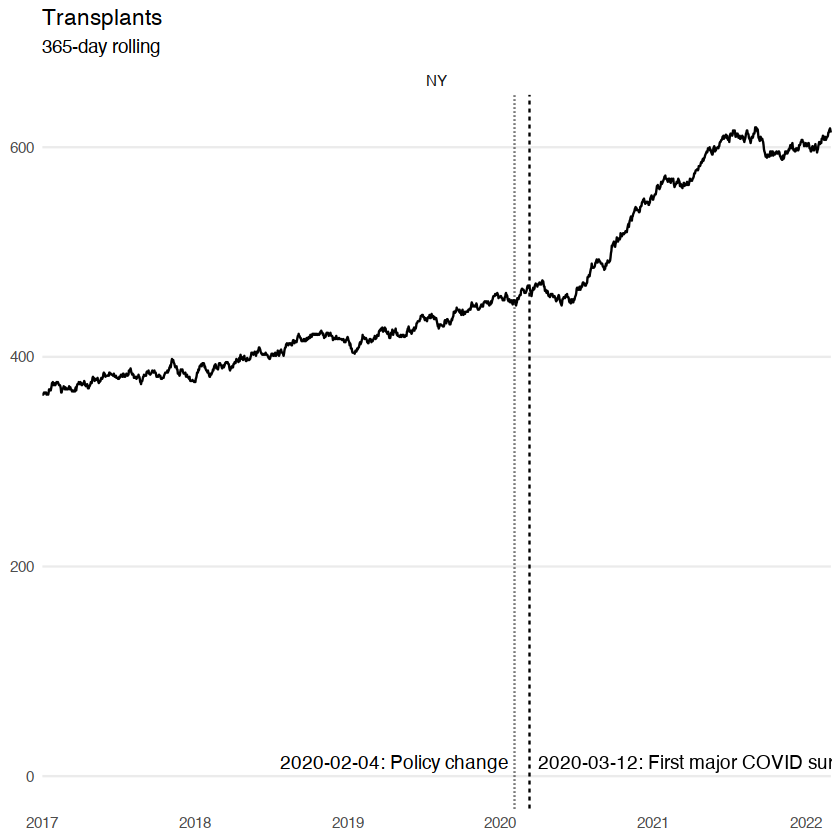

In [11]:
tx2 %>%
  filter(STATE == "NY",
         DATE >= as.Date("2017-01-01")) %>%
  ggplot(aes(x = DATE, y = N_TX_365D)) +
  geom_vline(xintercept = as.Date("2020-03-12"), linetype = "dashed") +
  geom_vline(xintercept = as.Date("2020-02-04"), linetype = "dotted") +
  geom_text(tibble(label = "2020-02-04: Policy change", x = as.Date("2020-02-04"), y = 0),
            mapping = aes(label = label, x = x, y = y), inherit.aes = F,
            vjust = -0.5, hjust = 1.025) +
  geom_text(tibble(label = "2020-03-12: First major COVID surge", x = as.Date("2020-03-12"), y = 0),
            mapping = aes(label = label, x = x, y = y), inherit.aes = F,
            vjust = -0.5, hjust = -0.025) +
  geom_line() +
  facet_wrap(~ STATE) +
  scale_x_date(name = NULL, date_labels = "%Y", date_breaks = "1 year", expand = c(0, 0)) +
  scale_y_continuous(name = NULL) +
  expand_limits(y = 0) +
  labs(title = "Transplants",
       subtitle = "365-day rolling") +
  theme_minimal() +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor = element_blank())

---

### Generate PDF sheet for each state

In [ ]:
setwd("output/figures/state_level_tx_plots/")

In [ ]:
for (i in 1:nrow(state_code_mapping)) {
  state_row <- state_code_mapping[i,]
  state <- state_row$STATE_CODE
    
  if (state == "VI") next
  if (txByYearState %>% filter(state == STATE) %>% nrow() == 0) next
  print(state_row$STATE_NAME)
  
  # create a plot of annual transplants (with % of national)
  plot1 <- txByYearState %>%
    filter(STATE == state) %>%
    pivot_longer(N_TX:PCT_TX, names_to = "SERIES", values_to = "VALUE") %>%
    mutate(SERIES = factor(SERIES, levels = c("N_TX", "PCT_TX"))) %>%
    ggplot(aes(x = YEAR, y = VALUE)) +
    geom_line(na.rm = T) +
    geom_point(na.rm = T) +
    scale_x_continuous(name = NULL) +
    scale_y_continuous(name = NULL, labels = function(l) {
      case_when(l >= 1 ~ scales::comma(l, accuracy = 1),
                l > 0 ~ scales::percent(l, accuracy = 0.01),
                T ~ scales::number(l)) %>%
        return()
    }) +
    facet_wrap(~ SERIES, scales = "free_y",
               labeller = labeller(SERIES = c("N_TX" = "# of Transplants",
                                              "PCT_TX" = "% of National Transplants"))) +
    labs(title = paste0(state_row$STATE_NAME, " (", state, ")"),
         subtitle = "Transplants, annual 2018 - 2021") +
    theme_bw() +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.minor = element_blank())
    
  # create a plot of 365-day rolling transplants  
  plot2 <- tx2 %>%
    filter(STATE == state,
         DATE >= as.Date("2017-01-01")) %>%
    ggplot(aes(x = DATE, y = N_TX_365D)) +
    geom_vline(xintercept = as.Date("2020-02-04"), linetype = "dotted") +
    geom_line() +
    scale_x_date(name = NULL, date_labels = "%b %d\n%Y", 
                 breaks = sort(c(seq.Date(as.Date("2017-01-01"), as.Date("2021-01-01"), "2 years "), 
                                 as.Date("2020-02-04"))), expand = c(0, 0)) +
    scale_y_continuous(name = NULL) +
    labs(subtitle = "Transplants, rolling 365d") +
    theme_minimal() +
    theme(panel.grid.major.x = element_blank(),
        panel.grid.minor = element_blank())
  
  # create a tableGrob for the 2019/2021 totals
  tbl <- txByYearState %>%
    mutate(across(matches("^N|PCT"), replace_na, 0)) %>%
    filter(STATE == state, YEAR %in% c(2019, 2021)) %>%
    arrange(YEAR) %>%
    select(Tx = N_TX) %>%
    tableGrob(rows = paste0(state, ", ", c(2019, 2021)))
  
  # export the combined stat sheet
  ggsave(paste0(state, "_state_level_tx_plots.pdf"), 
         plot1 + plot2 + tbl + plot_layout(design = "AAAAC\nAAAAC\nBBBBB\nBBBBB"),
         device = "pdf", width = 10, height = 5.6, unit = "in")
}

In [ ]:
# stitch all the PDFs together into one master deck
pdftools::pdf_combine(list.files(pattern = "*_state_level_tx_plots.pdf"), output = "../fig1-state_level_tx_plots.pdf")